# Content for 02_eda_feature_engineering.ipynb

This notebook loads enriched data from 01_data_collection.ipynb, performs EDA (descriptive stats, correlations, stationarity tests, distributions, heatmaps, time series plots, event analysis).
 It assumes enriched CSVs are in ENRICHED_DIR.
 Additional feature engineering (if any) can be added here, but lags are in modeling.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Set paths (same as notebook 1)
ROOT = os.getcwd()
DATA_DIR = os.path.join(ROOT, "data")
ENRICHED_DIR = os.path.join(DATA_DIR, "enriched")

# Commodity names (from tickers)
commodities = ["Gold", "WTI", "Wheat", "NaturalGas", "Copper", "Lithium"]
price_cols = {
    "Gold": "Close_GC=F",
    "WTI": "Close_CL=F",
    "Wheat": "Close_ZW=F",
    "NaturalGas": "Close_UNG",
    "Copper": "Close_HG=F",
    "Lithium": "Close_LIT"
}

# Load enriched data
merged_data = {}
for name in commodities:
    fname = f"{name.lower()}_enriched.csv"
    path = os.path.join(ENRICHED_DIR, fname)
    if os.path.exists(path):
        df = pd.read_csv(path)
        df['Date'] = pd.to_datetime(df['Date'])
        merged_data[name] = df
    else:
        print(f"Missing enriched file for {name}")

# EDA


--- EDA for Gold ---
            Return         MA_5        Vol_5  Return_lag1         GPRD  \
count  5342.000000  5342.000000  5342.000000  5342.000000  5342.000000   
mean      0.000418  1037.691516     0.009638     0.000416   100.638886   
std       0.011086   496.430245     0.005526     0.011086    53.969309   
min      -0.093538   257.220007     0.000449    -0.093538     3.570000   
25%      -0.004820   549.474988     0.005942    -0.004820    66.752500   
50%       0.000464  1189.979993     0.008465     0.000463    89.810000   
75%       0.006200  1347.560004     0.011776     0.006191   119.620000   
max       0.090277  2023.659985     0.053630     0.090277   706.400000   

       geo_keyword_hits    sentiment  Return_lag10  
count       4740.000000  4740.000000   5342.000000  
mean          24.276793     0.016337      0.000414  
std           10.433289     0.016647      0.011087  
min            0.000000    -0.090000     -0.093538  
25%           17.000000     0.006244     -0.00

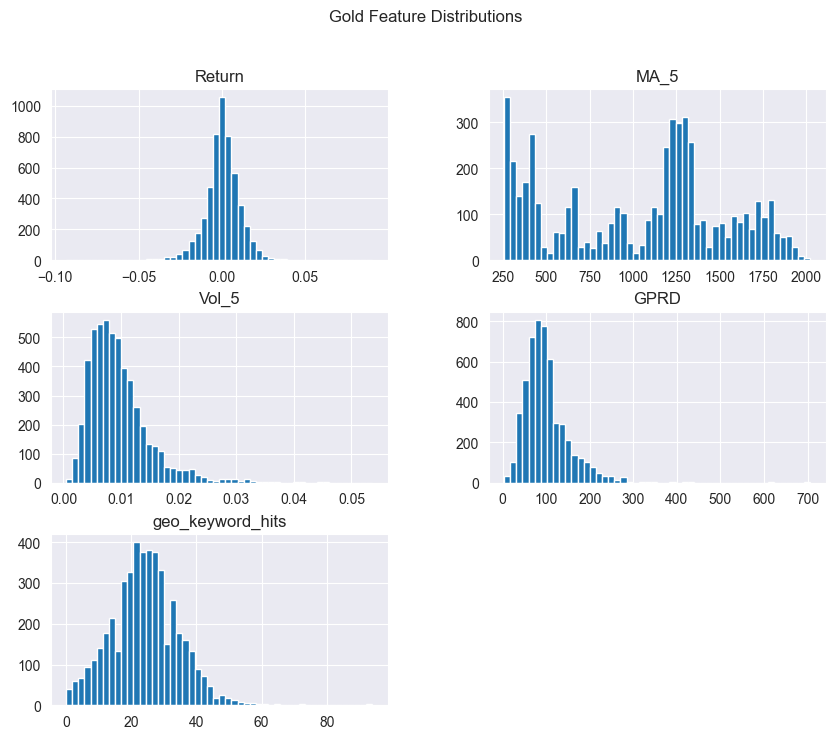

ADF Test for Price:
ADF Statistic: -0.817, p-value: 8.141e-01
ADF Test for Return:
ADF Statistic: -23.431, p-value: 0.000e+00


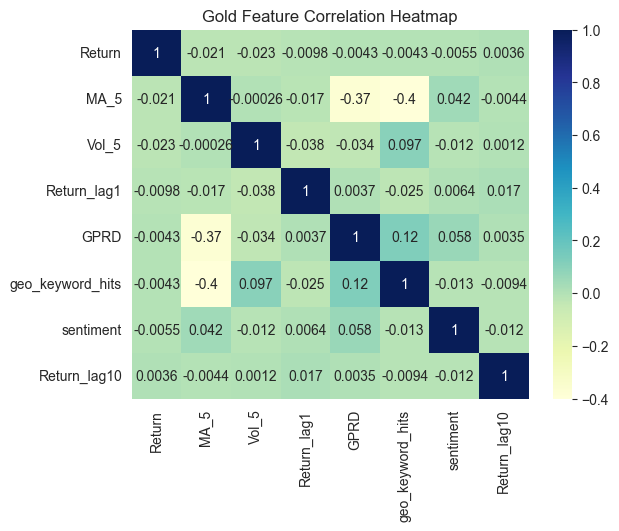

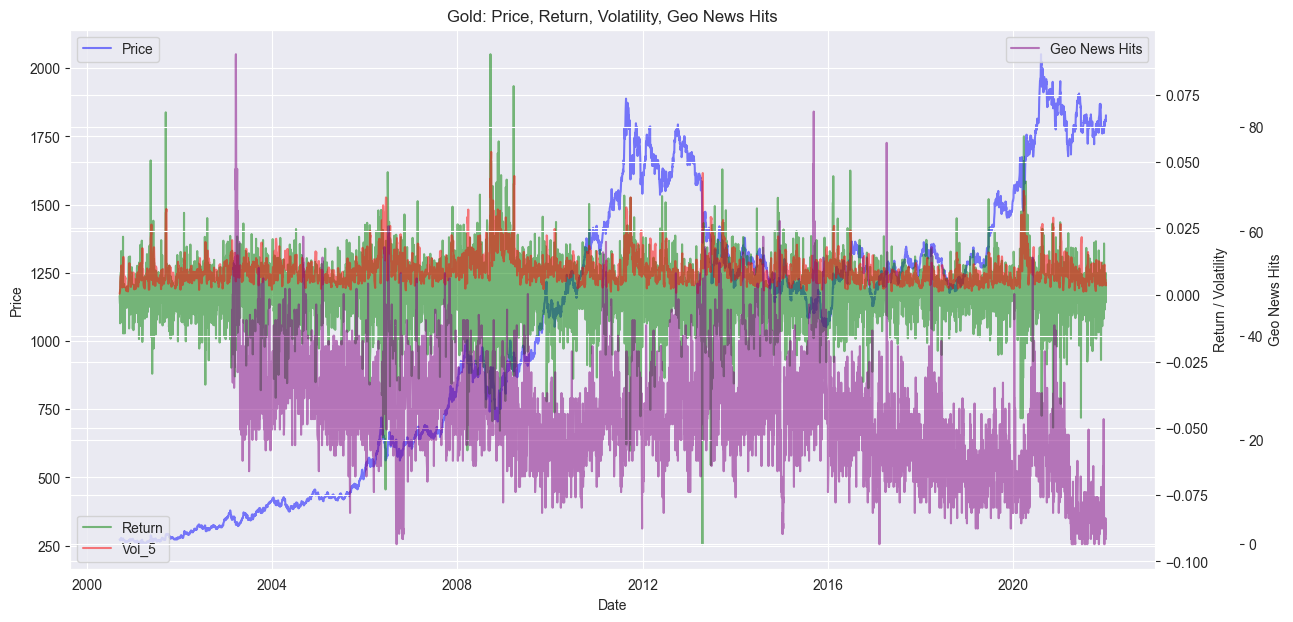


--- EDA for WTI ---
            Return         MA_5        Vol_5  Return_lag1         GPRD  \
count  5351.000000  5351.000000  5351.000000  5351.000000  5351.000000   
mean     -0.000208    62.191138     0.022519    -0.000202   100.565967   
std       0.052425    25.358765     0.045422     0.052424    53.968427   
min      -3.059661     3.920000     0.001544    -3.059661     3.570000   
25%      -0.012453    43.000000     0.012351    -0.012450    66.475000   
50%       0.001009    59.395999     0.017944     0.001020    89.810000   
75%       0.013243    81.218999     0.025210     0.013243   119.620000   
max       0.376623   142.239999     1.446609     0.376623   706.400000   

       geo_keyword_hits    sentiment  Return_lag10  
count       4744.000000  4744.000000   5351.000000  
mean          24.276981     0.016353     -0.000197  
std           10.431044     0.016649      0.052420  
min            0.000000    -0.090000     -3.059661  
25%           17.000000     0.006264     -0.012

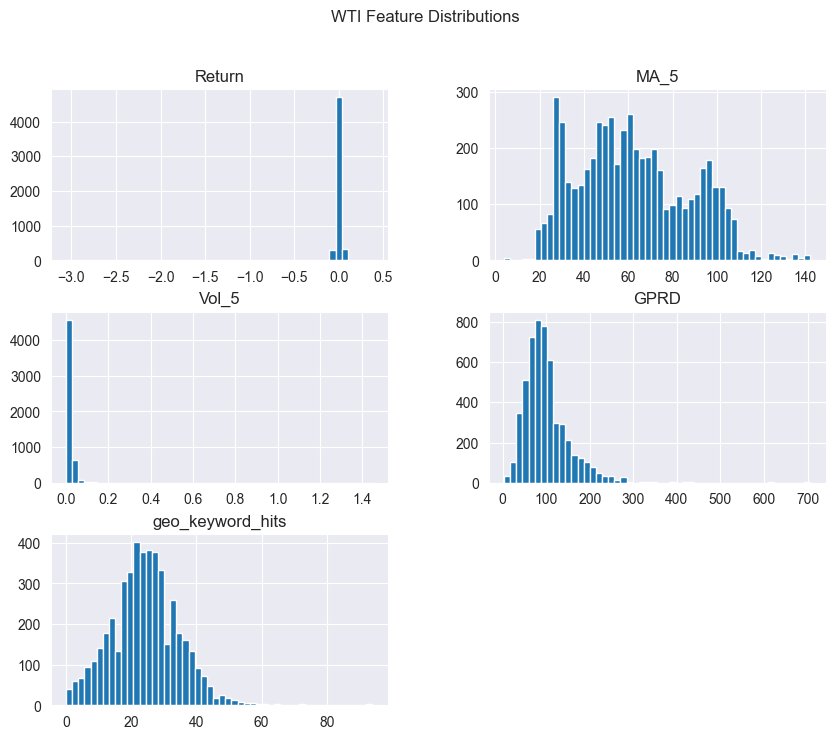

ADF Test for Price:
ADF Statistic: -2.585, p-value: 9.620e-02
ADF Test for Return:
ADF Statistic: -13.567, p-value: 2.255e-25


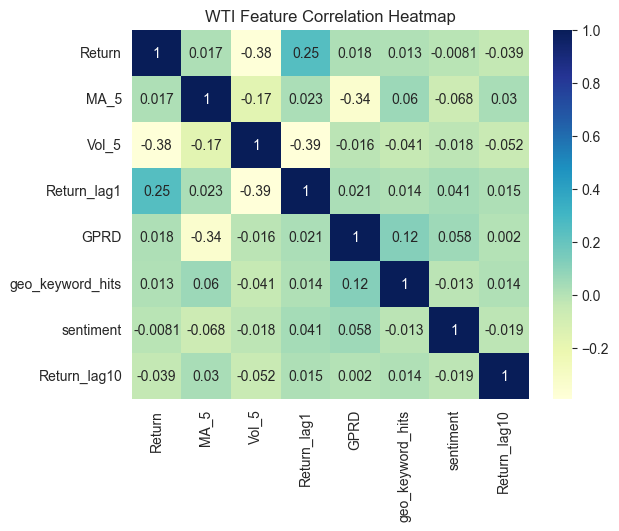

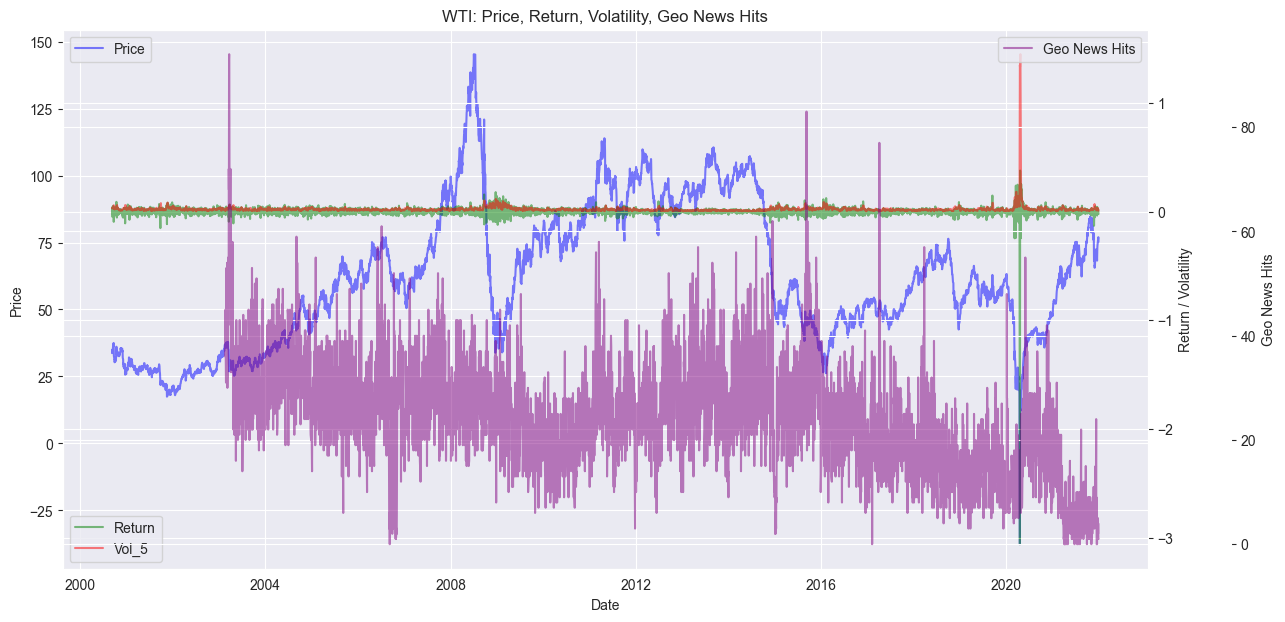


--- EDA for Wheat ---
            Return         MA_5        Vol_5  Return_lag1         GPRD  \
count  5367.000000  5367.000000  5367.000000  5367.000000  5367.000000   
mean      0.000410   514.694019     0.017919     0.000410   100.376516   
std       0.019876   170.923728     0.008797     0.019875    53.721536   
min      -0.094917   235.550000     0.001420    -0.094917     3.570000   
25%      -0.011935   381.875000     0.011780    -0.011935    66.140000   
50%      -0.000428   497.900000     0.016376    -0.000428    89.810000   
75%       0.011763   632.825000     0.021964     0.011763   119.620000   
max       0.091926  1208.800000     0.084186     0.091926   706.400000   

       geo_keyword_hits    sentiment  Return_lag10  
count       4751.000000  4751.000000   5367.000000  
mean          24.278047     0.016354      0.000411  
std           10.416239     0.016635      0.019869  
min            0.000000    -0.090000     -0.094917  
25%           18.000000     0.006255     -0.0

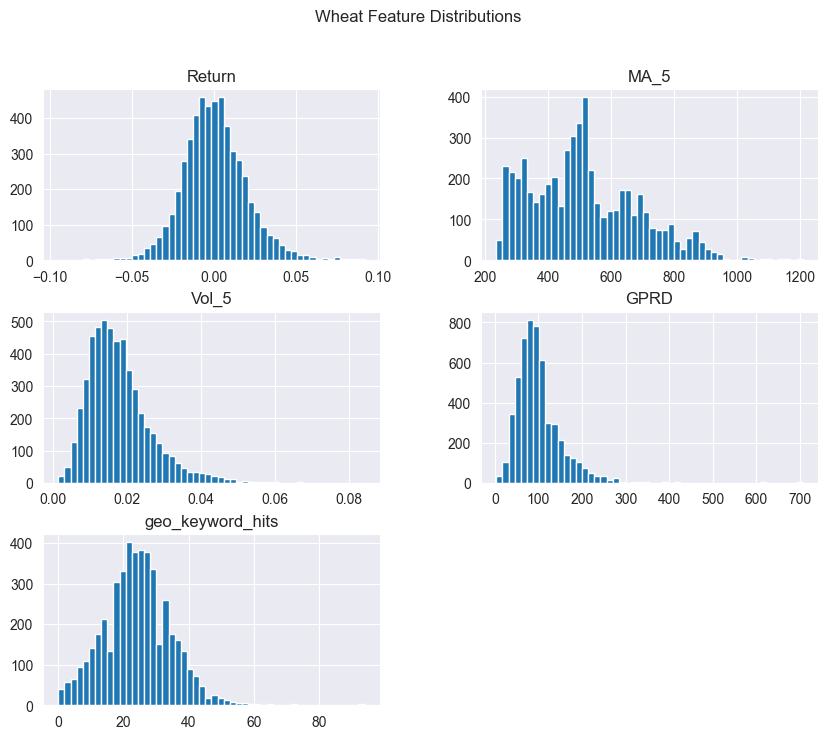

ADF Test for Price:
ADF Statistic: -2.306, p-value: 1.701e-01
ADF Test for Return:
ADF Statistic: -14.474, p-value: 6.543e-27


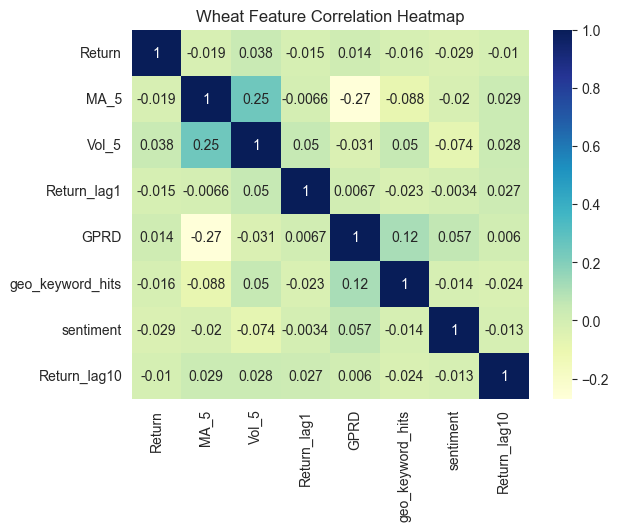

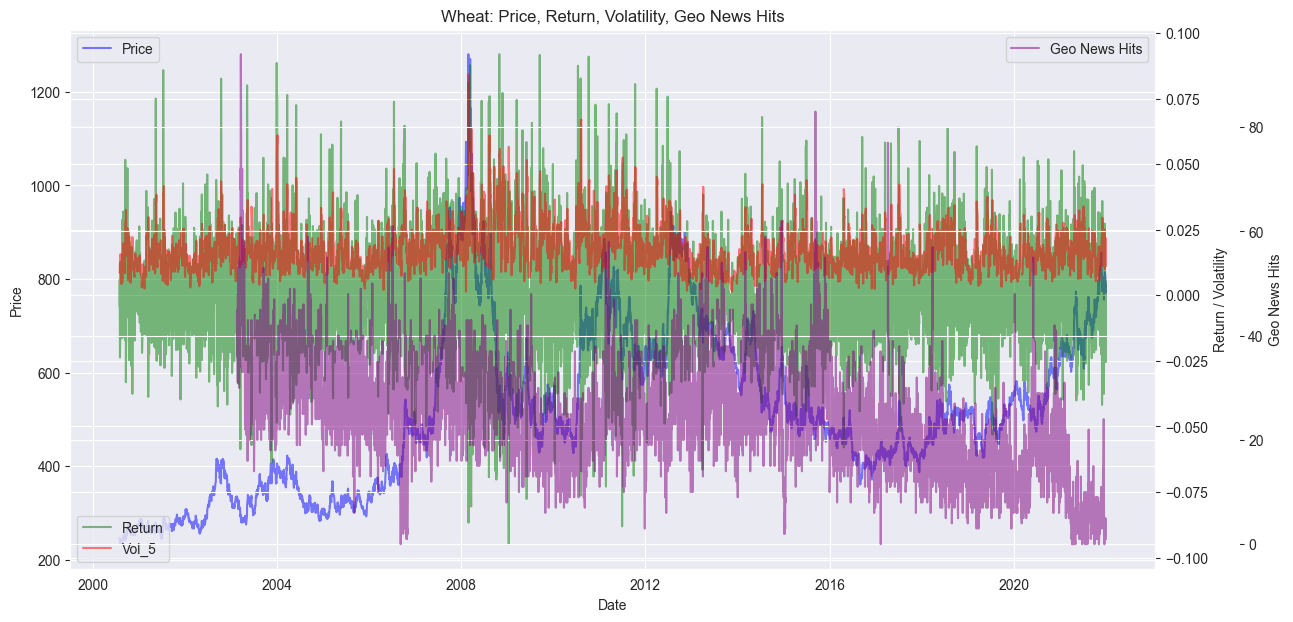


--- EDA for NaturalGas ---
            Return         MA_5        Vol_5  Return_lag1         GPRD  \
count  3694.000000  3694.000000  3694.000000  3694.000000  3694.000000   
mean     -0.000941   958.098556     0.024521    -0.000954    88.738671   
std       0.027550  1692.185825     0.012951     0.027538    39.389409   
min      -0.191251    35.632000     0.003104    -0.191251     3.570000   
25%      -0.017238    98.428000     0.015883    -0.017238    62.590000   
50%      -0.001403   287.087997     0.021714    -0.001403    85.230000   
75%       0.014760   748.095999     0.029932     0.014742   106.170000   
max       0.188993  8069.376074     0.144606     0.188993   413.460000   

       geo_keyword_hits    sentiment  Return_lag10  
count       3694.000000  3694.000000   3694.000000  
mean          22.538441     0.016110     -0.000944  
std            9.934555     0.017167      0.027479  
min            0.000000    -0.070115     -0.191251  
25%           16.000000     0.005542    

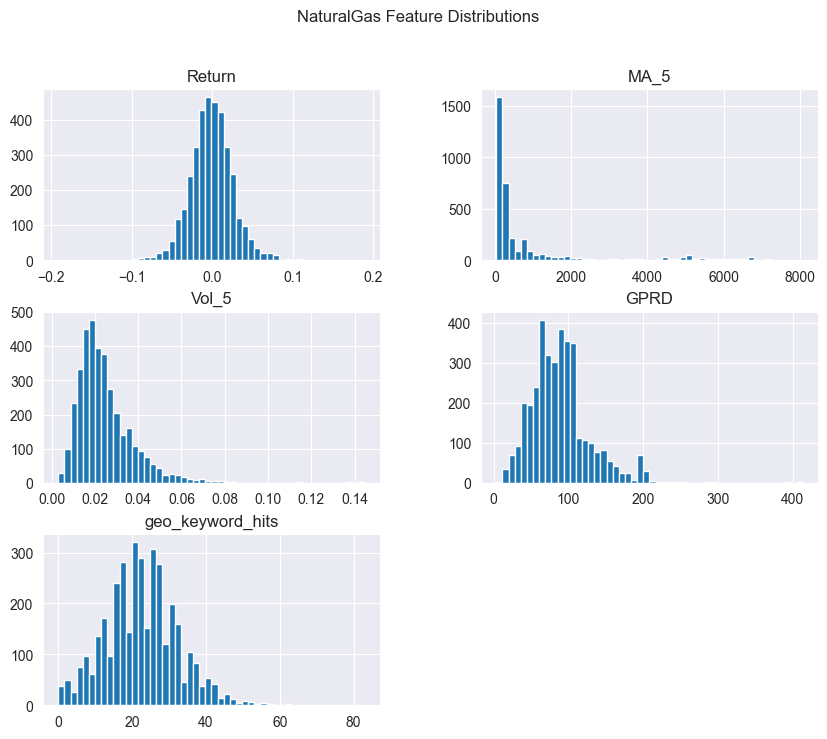

ADF Test for Price:
ADF Statistic: -3.412, p-value: 1.056e-02
ADF Test for Return:
ADF Statistic: -28.879, p-value: 0.000e+00


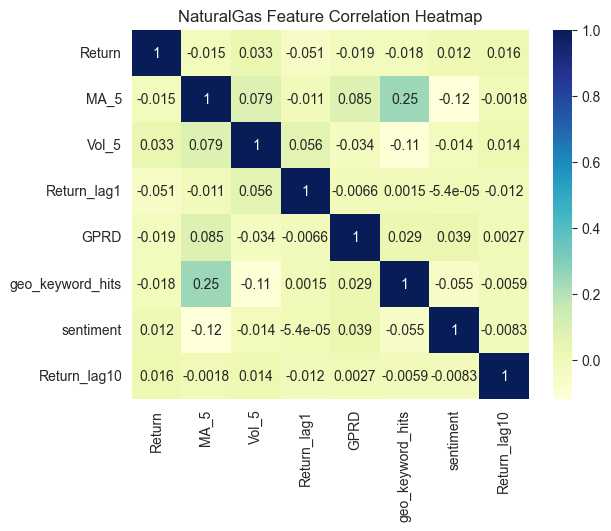

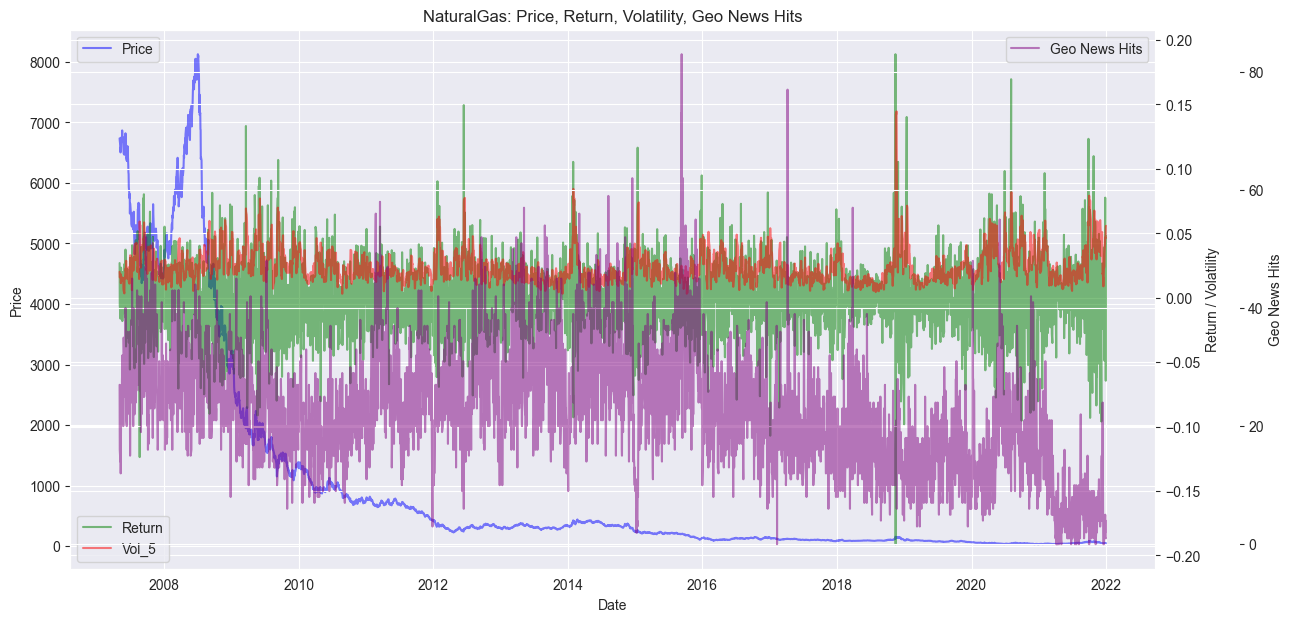


--- EDA for Copper ---
            Return         MA_5        Vol_5  Return_lag1         GPRD  \
count  5346.000000  5346.000000  5346.000000  5346.000000  5346.000000   
mean      0.000439     2.586139     0.014780     0.000436   100.684186   
std       0.017050     1.073002     0.008959     0.017048    54.038940   
min      -0.110355     0.611100     0.000770    -0.110355     3.570000   
25%      -0.008279     1.743775     0.008916    -0.008279    66.775000   
50%       0.000182     2.786900     0.012681     0.000175    89.870000   
75%       0.009174     3.357500     0.017932     0.009160   119.620000   
max       0.124898     4.747200     0.089962     0.124898   706.400000   

       geo_keyword_hits    sentiment  Return_lag10  
count       4743.000000  4743.000000   5346.000000  
mean          24.268396     0.016351      0.000441  
std           10.434683     0.016646      0.017048  
min            0.000000    -0.090000     -0.110355  
25%           17.000000     0.006264     -0.

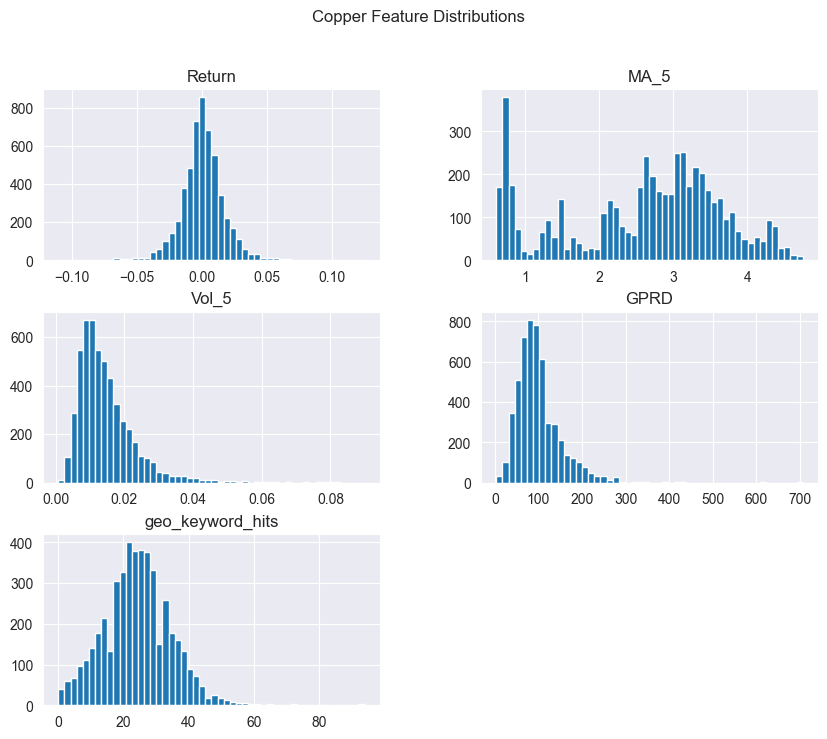

ADF Test for Price:
ADF Statistic: -1.600, p-value: 4.835e-01
ADF Test for Return:
ADF Statistic: -19.566, p-value: 0.000e+00


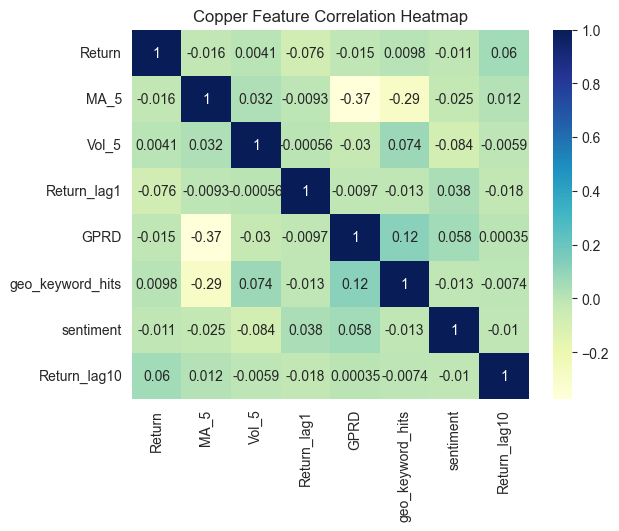

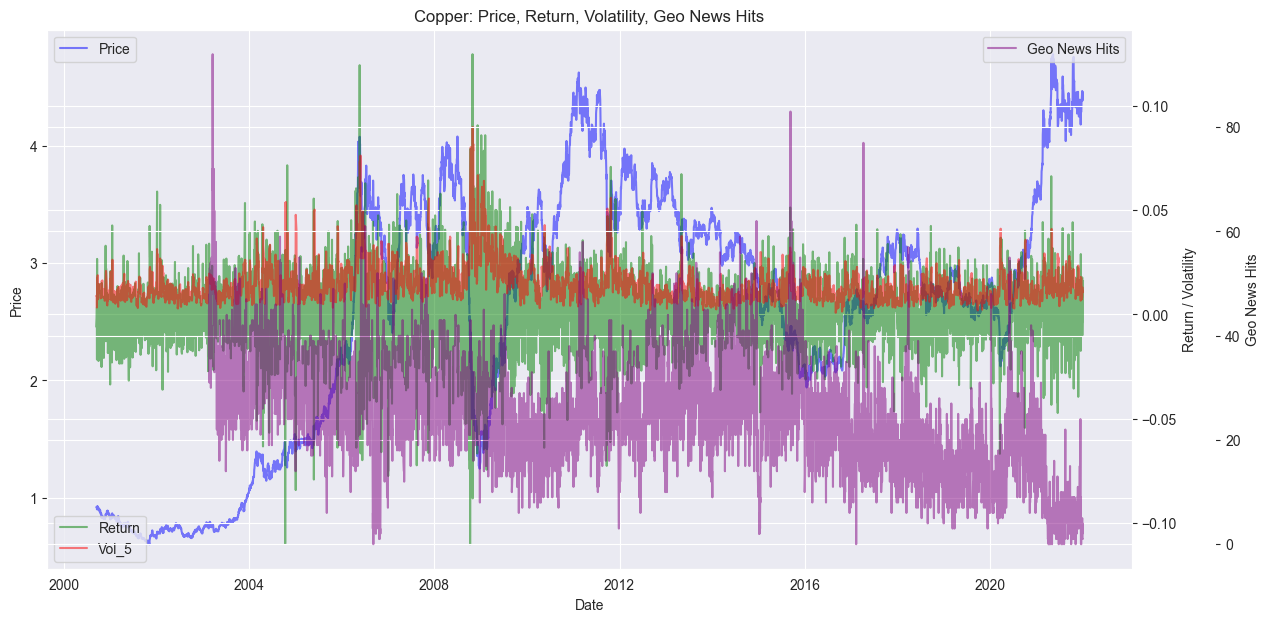


--- EDA for Lithium ---
            Return         MA_5        Vol_5  Return_lag1         GPRD  \
count  2871.000000  2871.000000  2871.000000  2871.000000  2871.000000   
mean      0.000513    30.099519     0.014051     0.000512    87.172807   
std       0.017040    14.824321     0.009310     0.017041    41.024432   
min      -0.135835    15.143248     0.001797    -0.135835     3.570000   
25%      -0.007488    21.980807     0.008182    -0.007541    60.885000   
50%       0.000784    25.217942     0.011910     0.000784    82.090000   
75%       0.009075    31.427054     0.017304     0.009075   104.310000   
max       0.148925    91.842505     0.086967     0.148925   413.460000   

       geo_keyword_hits    sentiment  Return_lag10  
count       2871.000000  2871.000000   2871.000000  
mean          21.845698     0.017488      0.000544  
std           10.391846     0.017921      0.017026  
min            0.000000    -0.070115     -0.135835  
25%           15.000000     0.006695     -0

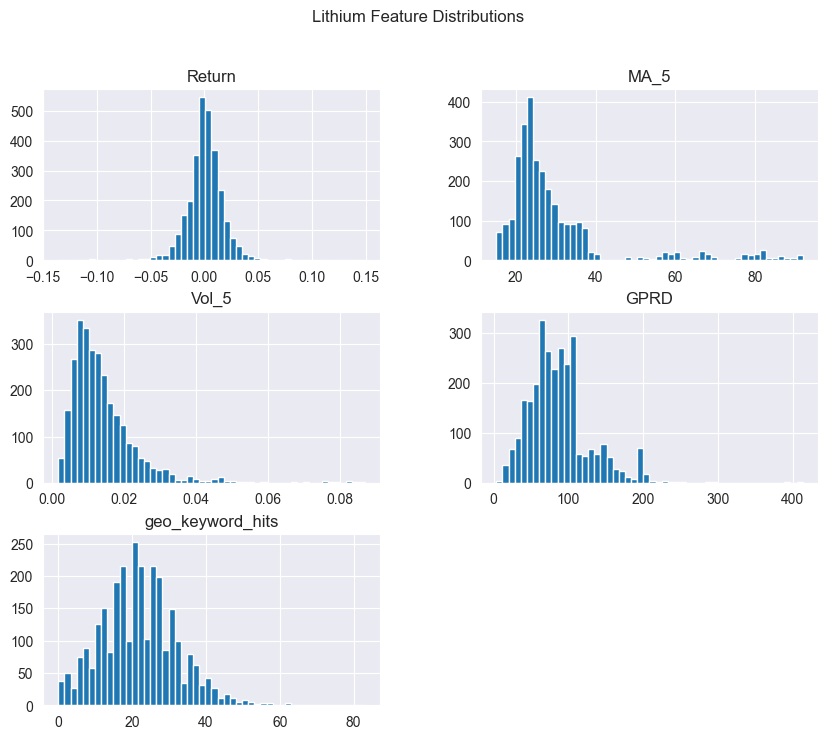

ADF Test for Price:
ADF Statistic: 0.536, p-value: 9.859e-01
ADF Test for Return:
ADF Statistic: -16.119, p-value: 4.923e-29


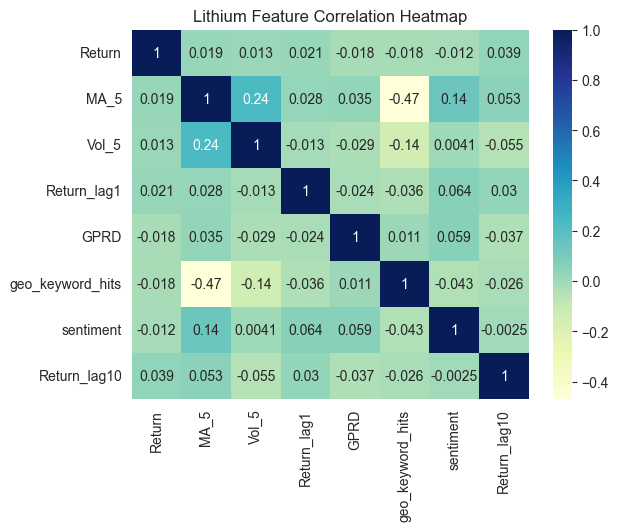

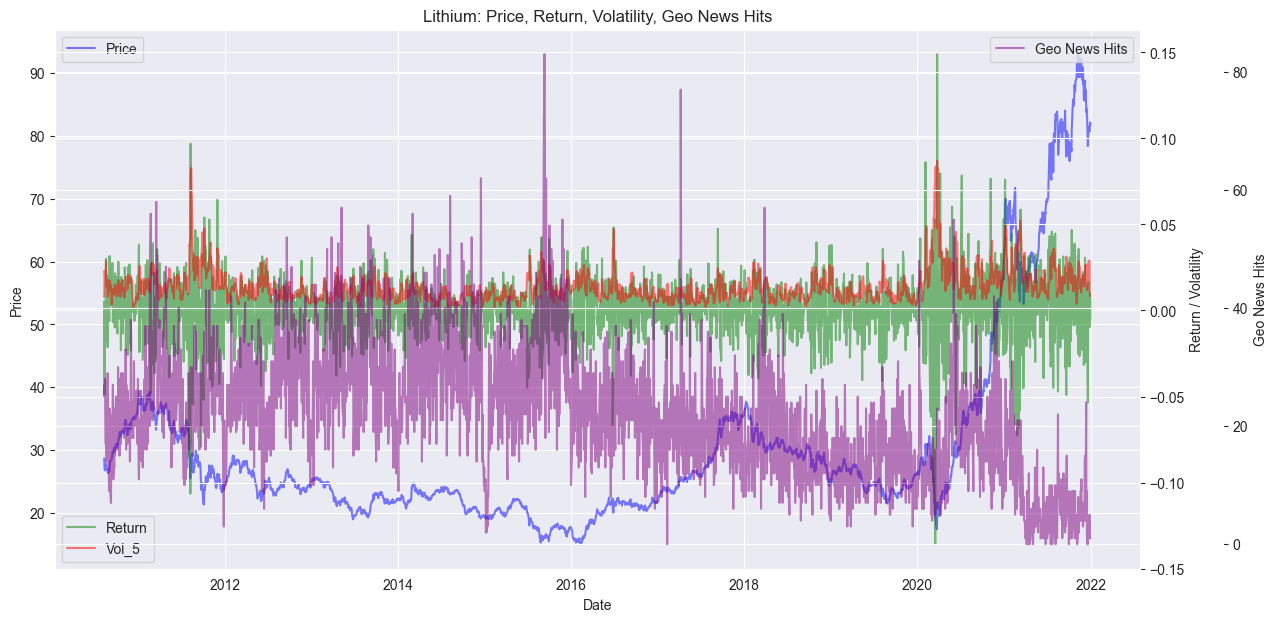


--- ADF Stationarity Tests for Gold ---
Price: ADF Statistic=-0.817, p-value=0.814
Return: ADF Statistic=-23.431, p-value=0
Price: Not stationary (fail to reject H0)
Return: Stationary (reject H0)

--- ADF Stationarity Tests for WTI ---
Price: ADF Statistic=-2.585, p-value=0.0962
Return: ADF Statistic=-13.567, p-value=2.26e-25
Price: Not stationary (fail to reject H0)
Return: Stationary (reject H0)

--- ADF Stationarity Tests for Wheat ---
Price: ADF Statistic=-2.306, p-value=0.17
Return: ADF Statistic=-14.474, p-value=6.54e-27
Price: Not stationary (fail to reject H0)
Return: Stationary (reject H0)

--- ADF Stationarity Tests for NaturalGas ---
Price: ADF Statistic=-3.412, p-value=0.0106
Return: ADF Statistic=-28.879, p-value=0
Price: Stationary (reject H0)
Return: Stationary (reject H0)

--- ADF Stationarity Tests for Copper ---
Price: ADF Statistic=-1.600, p-value=0.483
Return: ADF Statistic=-19.566, p-value=0
Price: Not stationary (fail to reject H0)
Return: Stationary (reject H0)

In [2]:
for name, df in merged_data.items():
    print(f"\n--- EDA for {name} ---")
    print(df[['Return','MA_5','Vol_5','Return_lag1','GPRD','geo_keyword_hits','sentiment', "Return_lag10"]].describe())
    # Correlations
    print("Correlation matrix:\n", df[['Return','MA_5','Vol_5','Return_lag1','GPRD','geo_keyword_hits','sentiment', "Return_lag10"]].corr())
    # Distribution plots
    df[['Return','MA_5','Vol_5','GPRD','geo_keyword_hits']].hist(figsize=(10,8), bins=50)
    plt.suptitle(f'{name} Feature Distributions')
    plt.show()
    # Stationarity test
    print("ADF Test for Price:")
    adf_result = adfuller(df[price_cols[name]])
    print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.3e}")
    print("ADF Test for Return:")
    adf_result = adfuller(df['Return'])
    print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.3e}")
    # Correlation heatmap
    corr = df[['Return','MA_5','Vol_5','Return_lag1','GPRD','geo_keyword_hits','sentiment', "Return_lag10"]].corr()
    sns.heatmap(corr, annot=True, cmap='YlGnBu')
    plt.title(f'{name} Feature Correlation Heatmap')
    plt.show()
    # Time series multi-axis plot
    fig, ax1 = plt.subplots(figsize=(14,7))
    ax1.plot(df['Date'], df[price_cols[name]], label='Price', color='blue', alpha=0.5)
    ax2 = ax1.twinx()
    ax2.plot(df['Date'], df['Return'], label='Return', color='green', alpha=0.5)
    ax2.plot(df['Date'], df['Vol_5'], label='Vol_5', color='red', alpha=0.5)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(df['Date'], df['geo_keyword_hits'], label='Geo News Hits', color='purple', alpha=0.5)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax2.set_ylabel('Return / Volatility')
    ax3.set_ylabel('Geo News Hits')
    ax1.legend(loc='upper left')
    ax2.legend(loc='lower left')
    ax3.legend(loc='upper right')
    plt.title(f'{name}: Price, Return, Volatility, Geo News Hits')
    plt.show()

# Additional Stationarity Tests
for name, df in merged_data.items():
    print(f"\n--- ADF Stationarity Tests for {name} ---")
    # Test price series
    adf_price = adfuller(df[price_cols[name]].dropna())
    print(f"Price: ADF Statistic={adf_price[0]:.3f}, p-value={adf_price[1]:.3g}")
    # Test returns series
    adf_return = adfuller(df['Return'].dropna())
    print(f"Return: ADF Statistic={adf_return[0]:.3f}, p-value={adf_return[1]:.3g}")

    # Interpret
    if adf_price[1]<0.05:
        print("Price: Stationary (reject H0)")
    else:
        print("Price: Not stationary (fail to reject H0)")
    if adf_return[1]<0.05:
        print("Return: Stationary (reject H0)")
    else:
        print("Return: Not stationary (fail to reject H0)")

for name, df in merged_data.items():
    print(f"\n--- Stationarity (ADF) for {name} ---")
    # MA5 stationarity
    if 'MA_5' in df.columns:
        adf_ma5 = adfuller(df['MA_5'].dropna())
        print(f"MA5:  ADF Statistic={adf_ma5[0]:.3f}, p-value={adf_ma5[1]:.3g} -- ", end="")
        print("Stationary" if adf_ma5[1]<0.05 else "Not stationary")
    # Volatility stationarity
    if 'Vol_5' in df.columns:
        adf_vol = adfuller(df['Vol_5'].dropna())
        print(f"Vol_5: ADF Statistic={adf_vol[0]:.3f}, p-value={adf_vol[1]:.3g} -- ", end="")
        print("Stationary" if adf_vol[1]<0.05 else "Not stationary")


--- Event Analysis for Gold ---
Average pre-event return: 0.00232141624030635
Average post-event return: 0.0027995014448993103


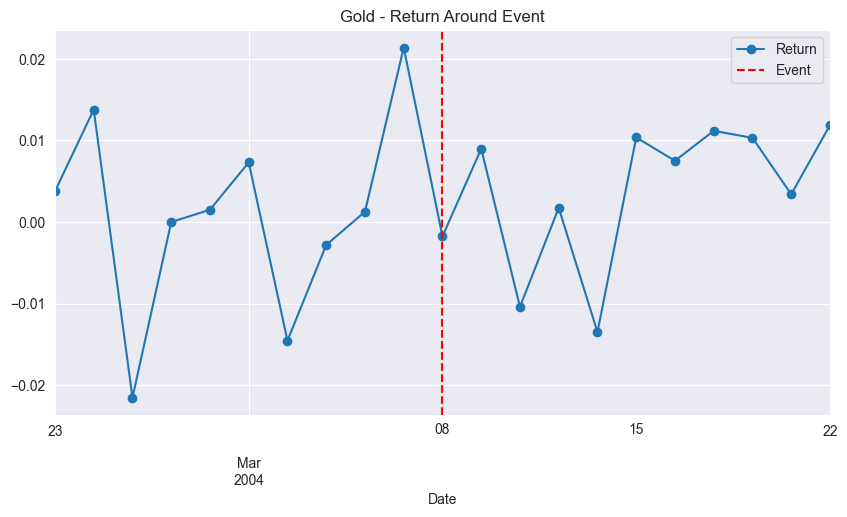


--- Event Analysis for WTI ---
Average pre-event return: 0.0036991901838200293
Average post-event return: 0.0020301735848626806


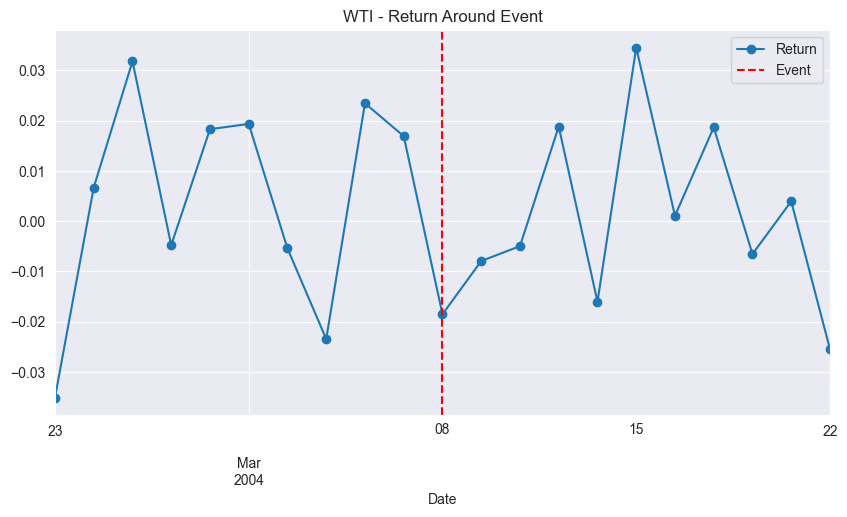


--- Event Analysis for Wheat ---
Average pre-event return: -0.001143557042425775
Average post-event return: 0.011981996826898945


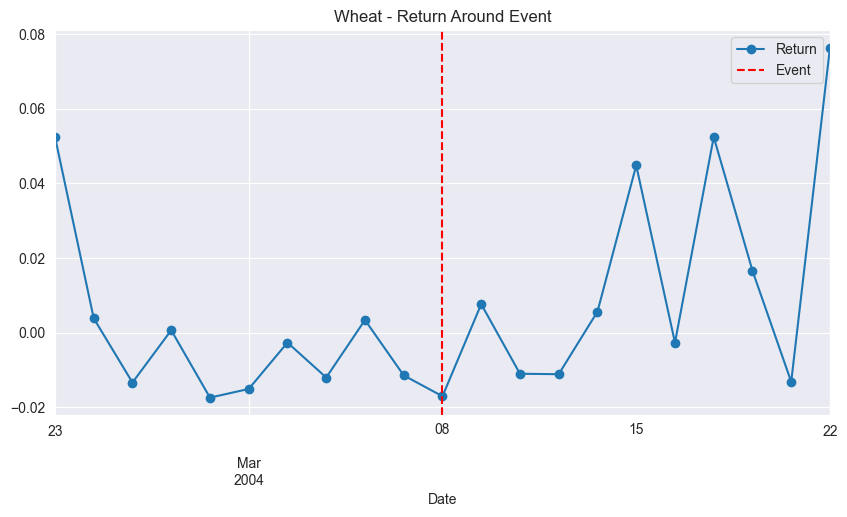


--- Event Analysis for NaturalGas ---
Average pre-event return: 0.00343589041099975
Average post-event return: 0.002609273533438159


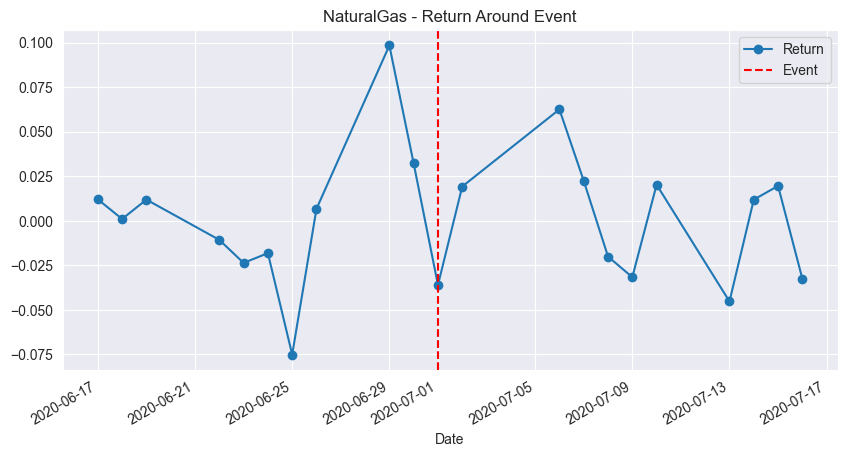


--- Event Analysis for Copper ---
Average pre-event return: 0.004114478515804865
Average post-event return: 0.00553724855632112


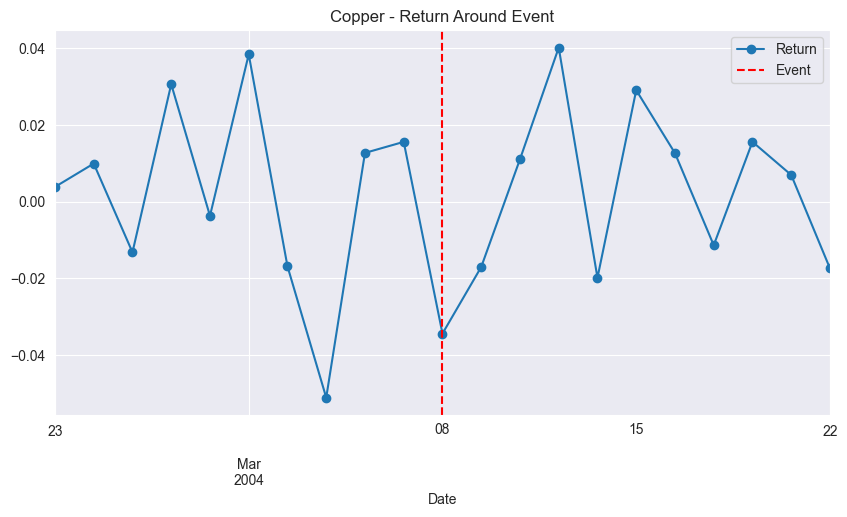


--- Event Analysis for Lithium ---
Average pre-event return: 0.0026350795208320904
Average post-event return: 0.011485941290310607


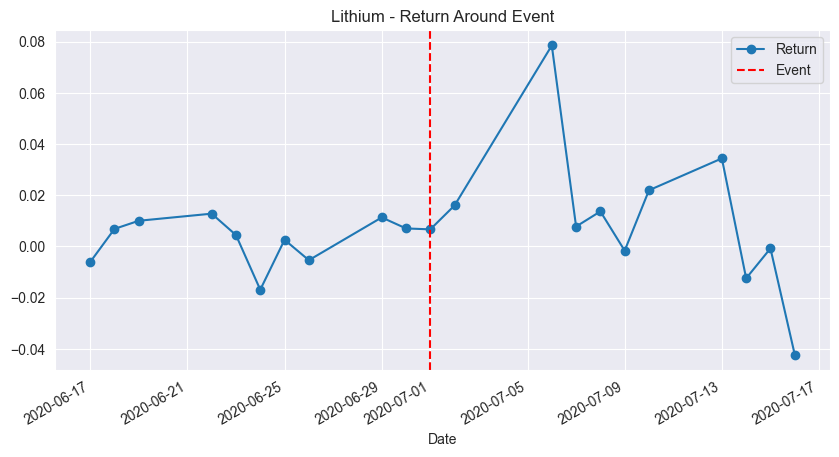


--- Event Analysis and Visualization for Gold ---


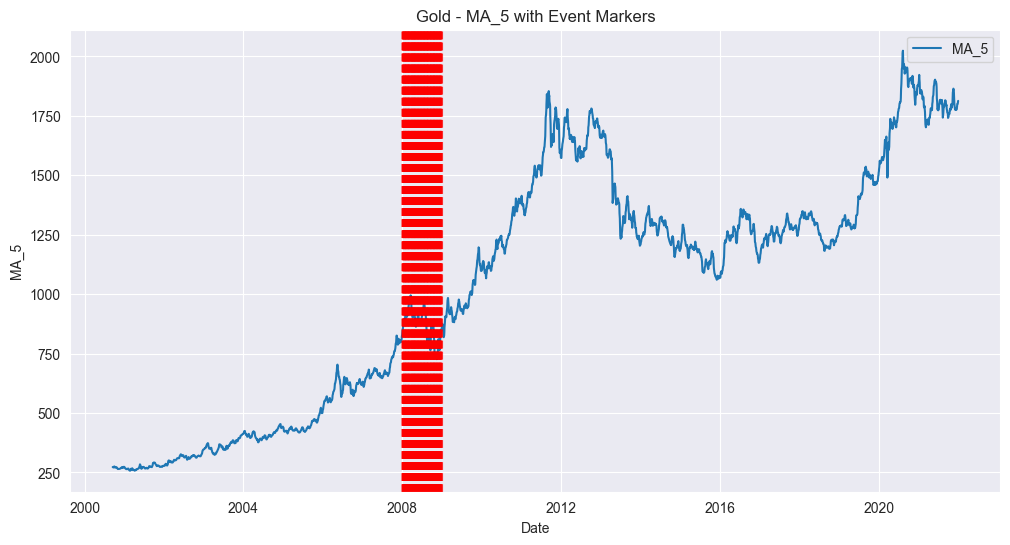

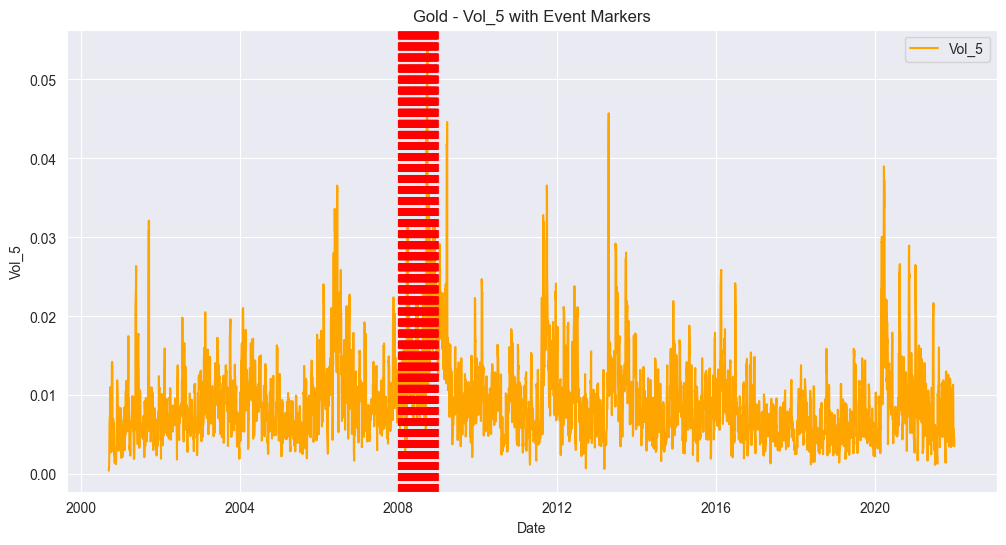

Mean volatility pre-event Vol_5:  0.0087
Mean volatility post-event Vol_5: 0.0113

--- Event Analysis and Visualization for WTI ---


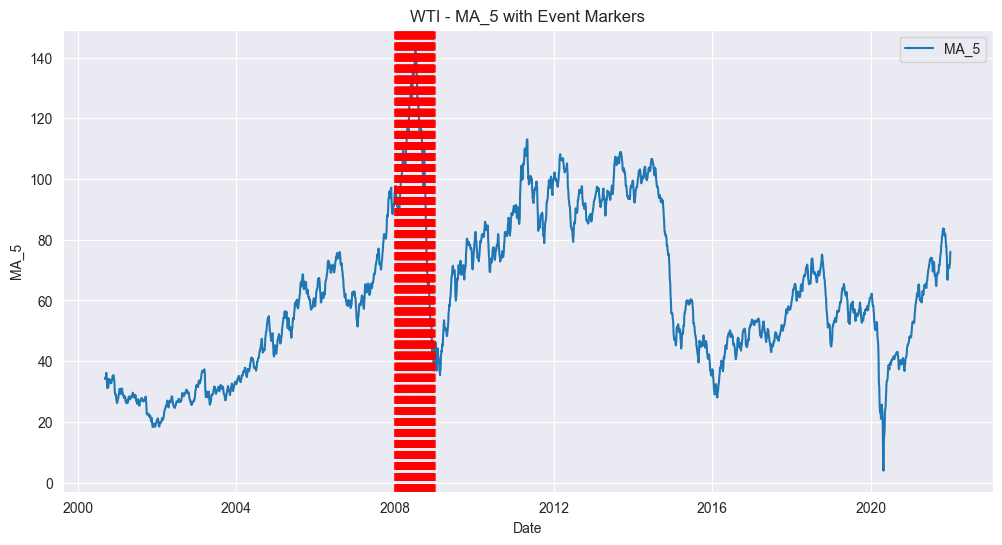

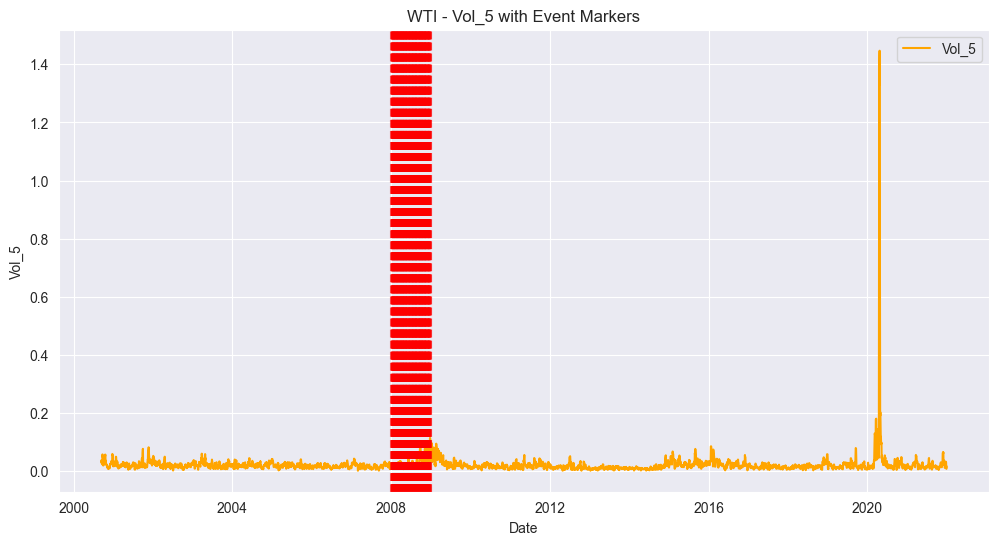

Mean volatility pre-event Vol_5:  0.0142
Mean volatility post-event Vol_5: 0.0183

--- Event Analysis and Visualization for Wheat ---


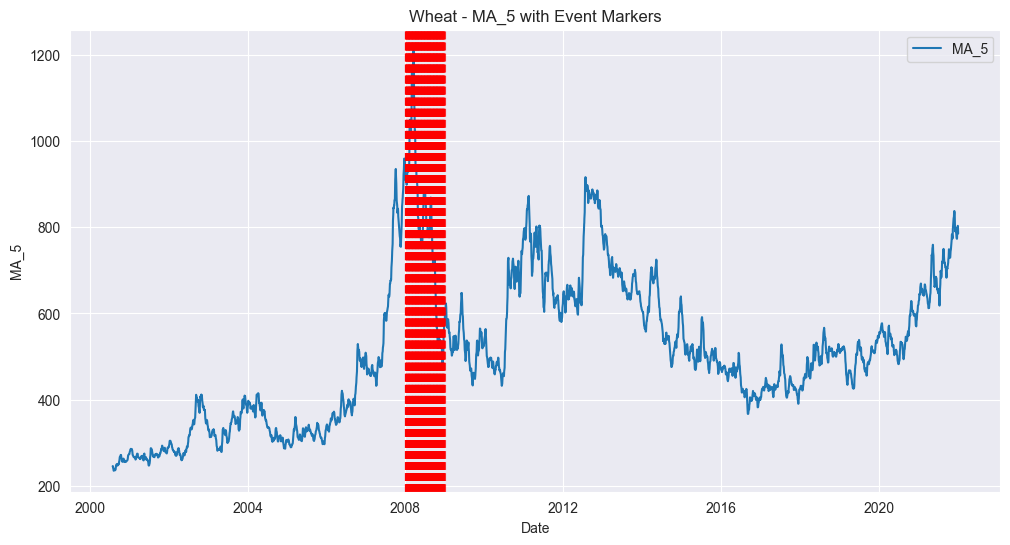

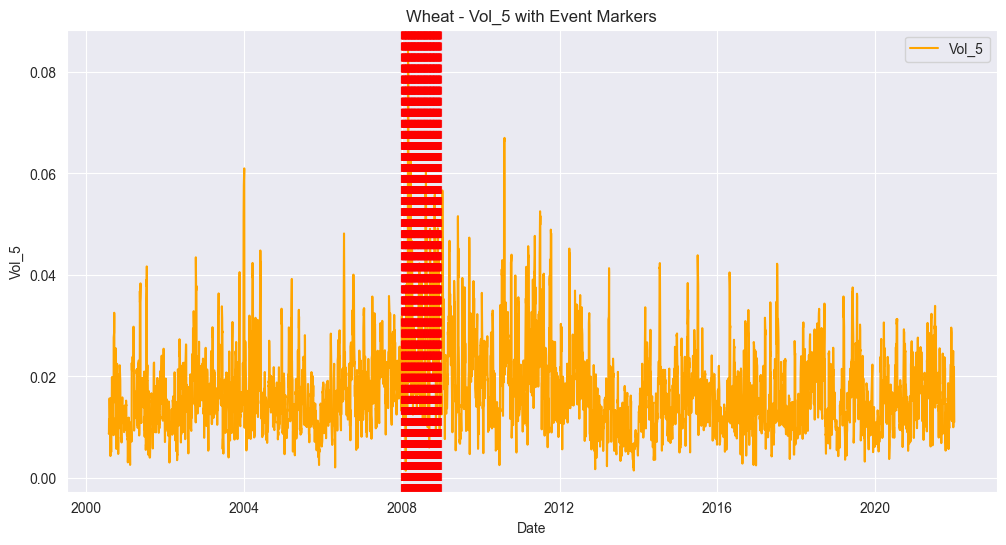

Mean volatility pre-event Vol_5:  0.0190
Mean volatility post-event Vol_5: 0.0235

--- Event Analysis and Visualization for NaturalGas ---


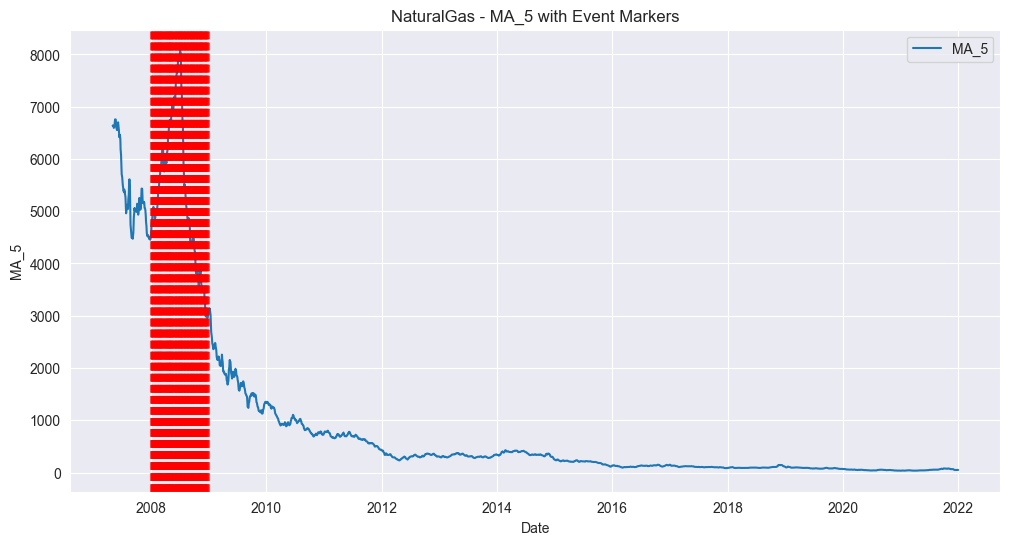

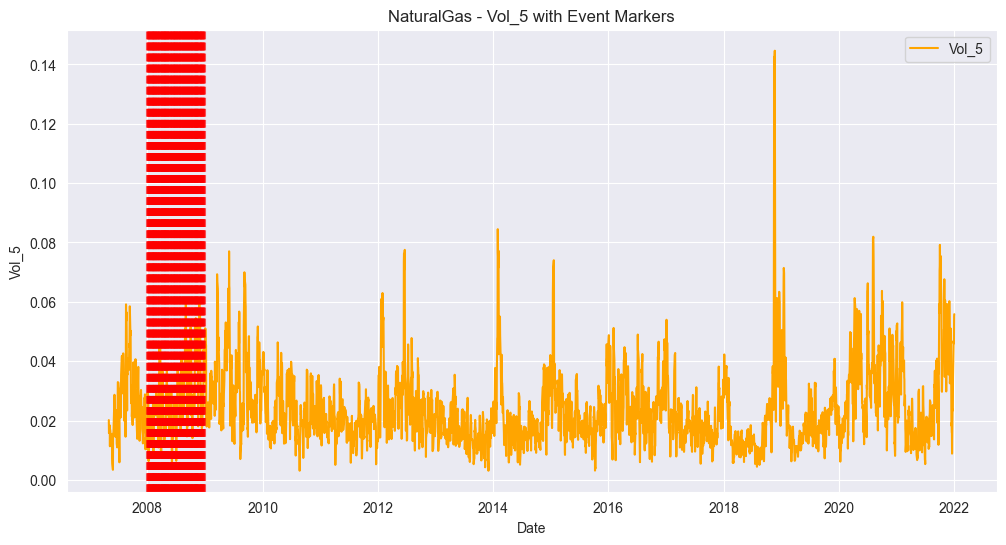

Mean volatility pre-event Vol_5:  0.0170
Mean volatility post-event Vol_5: 0.0215

--- Event Analysis and Visualization for Copper ---


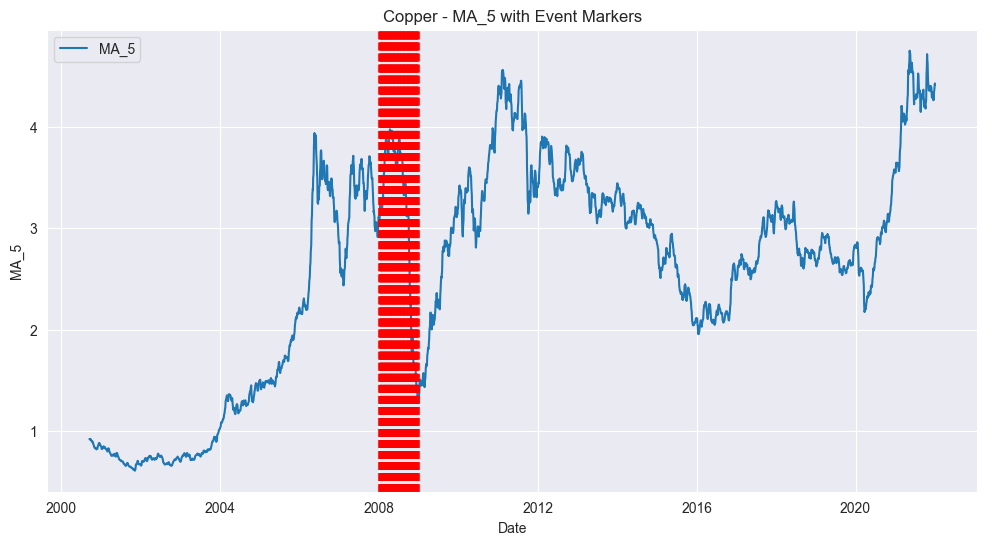

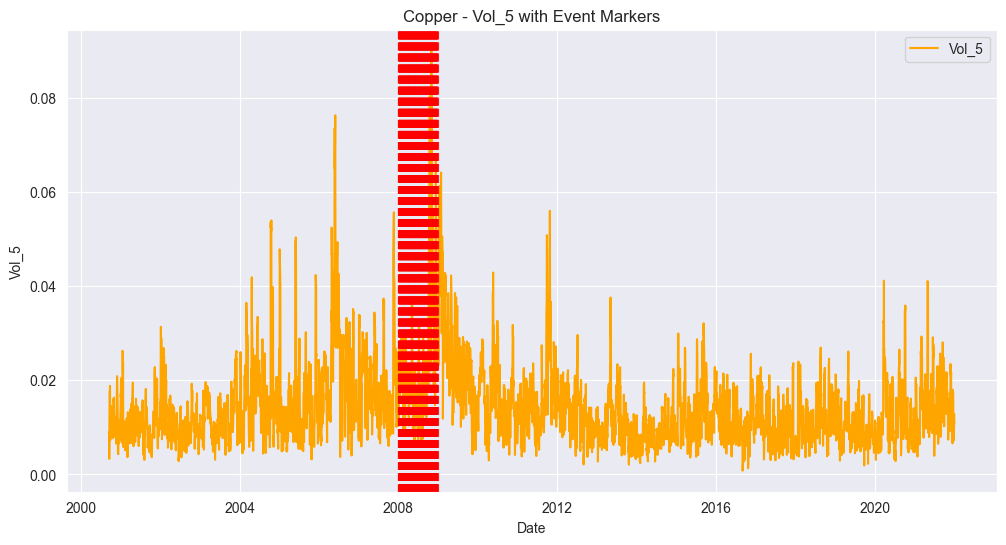

Mean volatility pre-event Vol_5:  0.0185
Mean volatility post-event Vol_5: 0.0219

--- Event Analysis and Visualization for Lithium ---


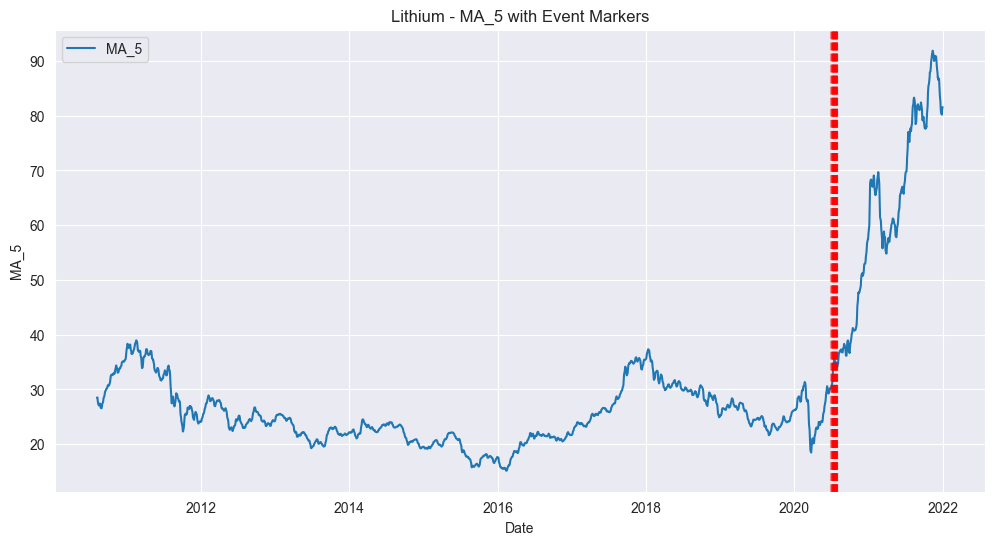

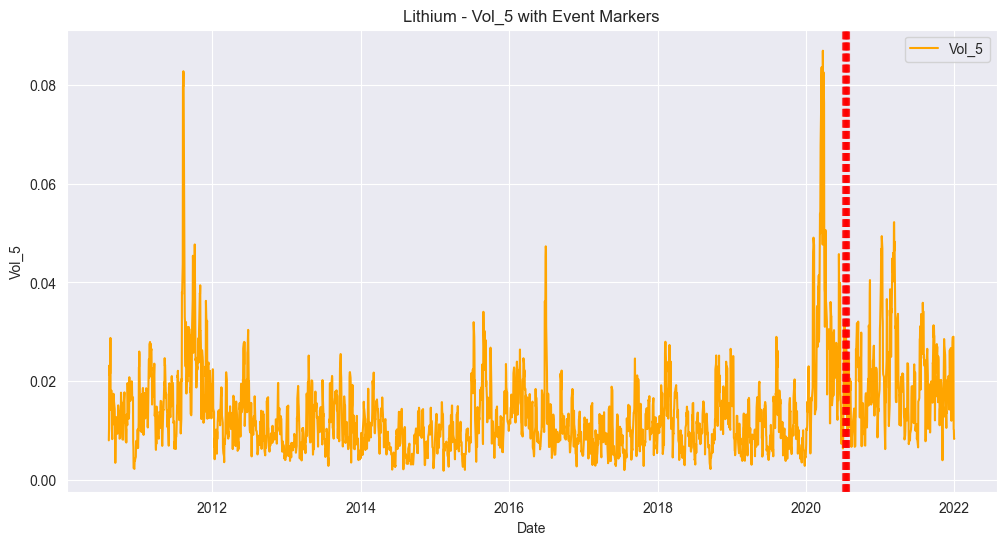

Mean volatility pre-event Vol_5:  0.0151
Mean volatility post-event Vol_5: 0.0245
EDA complete.


In [3]:
# Event Analysis
event_window = 10  # Days before and after event

for name, df in merged_data.items():
    print(f"\n--- Event Analysis for {name} ---")
    if 'event_dummy' in df.columns and df['event_dummy'].sum() > 0:
        event_indices = df.index[df['event_dummy']==1].tolist()
        pre_event_returns, post_event_returns = [], []
        for idx in event_indices:
            if idx>event_window and idx<len(df)-event_window:
                pre_event_returns.append(df.loc[idx-event_window:idx-1, 'Return'].mean())
                post_event_returns.append(df.loc[idx+1:idx+event_window, 'Return'].mean())

        print("Average pre-event return:", np.mean(pre_event_returns))
        print("Average post-event return:", np.mean(post_event_returns))

        # Plot for one example event window (the first event)
        if event_indices:
            idx = event_indices[0]
            fig, ax = plt.subplots(figsize=(10,5))
            window_df = df.loc[idx-event_window:idx+event_window]
            window_df = window_df.set_index('Date')
            window_df['Return'].plot(ax=ax, marker='o')
            ax.axvline(df.loc[idx, 'Date'], color='red', linestyle='--', label='Event')
            plt.title(f"{name} - Return Around Event")
            plt.legend()
            plt.show()
    else:
        print("No event dummies found in data, skipping event analysis.")

for name, df in merged_data.items():
    print(f"\n--- Event Analysis and Visualization for {name} ---")
    # Determine event dates: 2008 for most, July 2020 for lithium
    if name.lower() == 'lithium':
        event_dates = df[(df['Date'] >= '2020-07-01') & (df['Date'] < '2020-08-01')]['Date']
    else:
        event_dates = df[df['Date'].dt.year == 2008]['Date']

    # Plot MA_5 with all events marked
    if 'MA_5' in df.columns:
        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'], df['MA_5'], label='MA_5')
        for ed in event_dates:
            plt.axvline(ed, color='red', linestyle='--', alpha=0.4)
        plt.title(f"{name} - MA_5 with Event Markers")
        plt.xlabel("Date")
        plt.ylabel("MA_5")
        plt.legend()
        plt.show()

    # Plot Vol_5 with all events marked
    if 'Vol_5' in df.columns:
        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'], df['Vol_5'], color='orange', label='Vol_5')
        for ed in event_dates:
            plt.axvline(ed, color='red', linestyle='--', alpha=0.4)
        plt.title(f"{name} - Vol_5 with Event Markers")
        plt.xlabel("Date")
        plt.ylabel("Vol_5")
        plt.legend()
        plt.show()

    # Optional: Print mean volatility pre/post-event for quick check
    if len(event_dates) > 0 and 'Vol_5' in df.columns:
        # Use first event only for simple analysis
        idx = df.index[df['Date']==event_dates.iloc[0]][0]
        window = 10
        if idx > window and idx < len(df)-window:
            pre = df.loc[idx-window:idx-1, 'Vol_5'].mean()
            post = df.loc[idx+1:idx+window, 'Vol_5'].mean()
            print(f"Mean volatility pre-event Vol_5:  {pre:.4f}")
            print(f"Mean volatility post-event Vol_5: {post:.4f}")

print("EDA complete.")